In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import os
import numpy as np
from irc.manager import AgentManager

if not os.path.exists('example-agent'):
    os.mkdir('example-agent')
rng = np.random.default_rng()

In [2]:
manager = AgentManager('store', defaults='irc-defaults.yaml')
key = '3440A875'
config = manager.configs[key]
print('env_param:\n{}'.format(config.env_param))
print('task:\n{}'.format(config.task))

env_param:
[1.0, 0.001, 0.1, 0.0, 0.0286, 0.2, 0.0286, 0.2, 0.0667, 0.2]
task:
{'ent_coef': 0.04, 'gamma': 0.99}


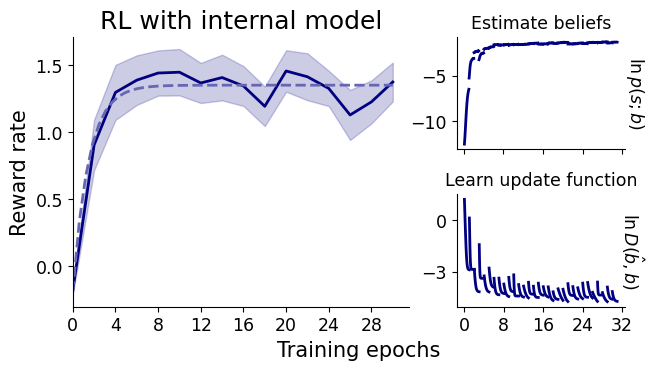

In [3]:
agent, fig = manager.inspect_agent(key, to_plot_stats=True)

In [4]:
max_steps = 100

for e in manager.ckpt['history']:
    agent.load_state_dict(manager.ckpt['history'][e])
    episode = agent.run_one_episode(max_steps=max_steps)
    fig, ani = agent.model.env.play_episode(episode, aname='example-agent/epoch-{:02d}.gif'.format(e))
    plt.close(fig)

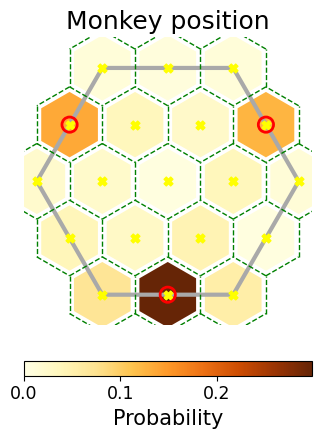

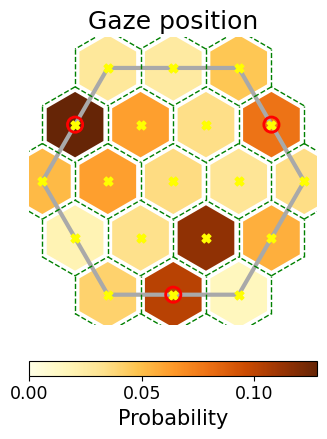

In [5]:
episodes = agent.run_episodes(total_steps=10000, max_steps=100)

fig_p, fig_g = agent.model.env.plot_occupancy(episodes)

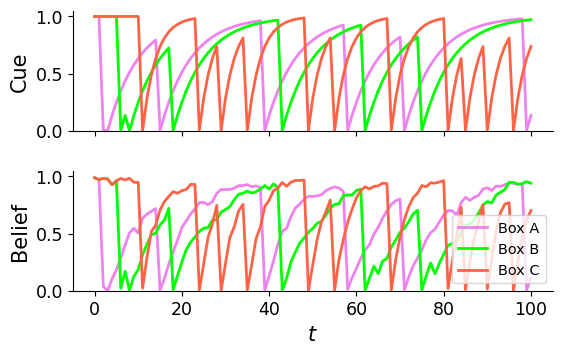

In [6]:
episode = rng.choice(episodes)
fig, ani = agent.model.env.play_box_beliefs(episode, agent.model.p_s)